# Import

In [2]:
import tensorflow as tf
from tensorflow import keras

# to work with directories
import splitfolders
from pathlib import Path
import os
import numpy as np

# to sort files in directory
import natsort

# to work with images
import matplotlib.pyplot as plt

# image preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# model building
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

# for tests
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Research

In [3]:
partitures_data_path = "data/partitures/"
other_data_path = "data/other/"

In [4]:
# take names and sort them
input_folder = "data/"

partitures_filenames = os.listdir(partitures_data_path)
image_filenames = natsort.natsorted(partitures_filenames)

other_filenames = os.listdir(other_data_path)
other_filenames = natsort.natsorted(other_filenames)

## Partitures

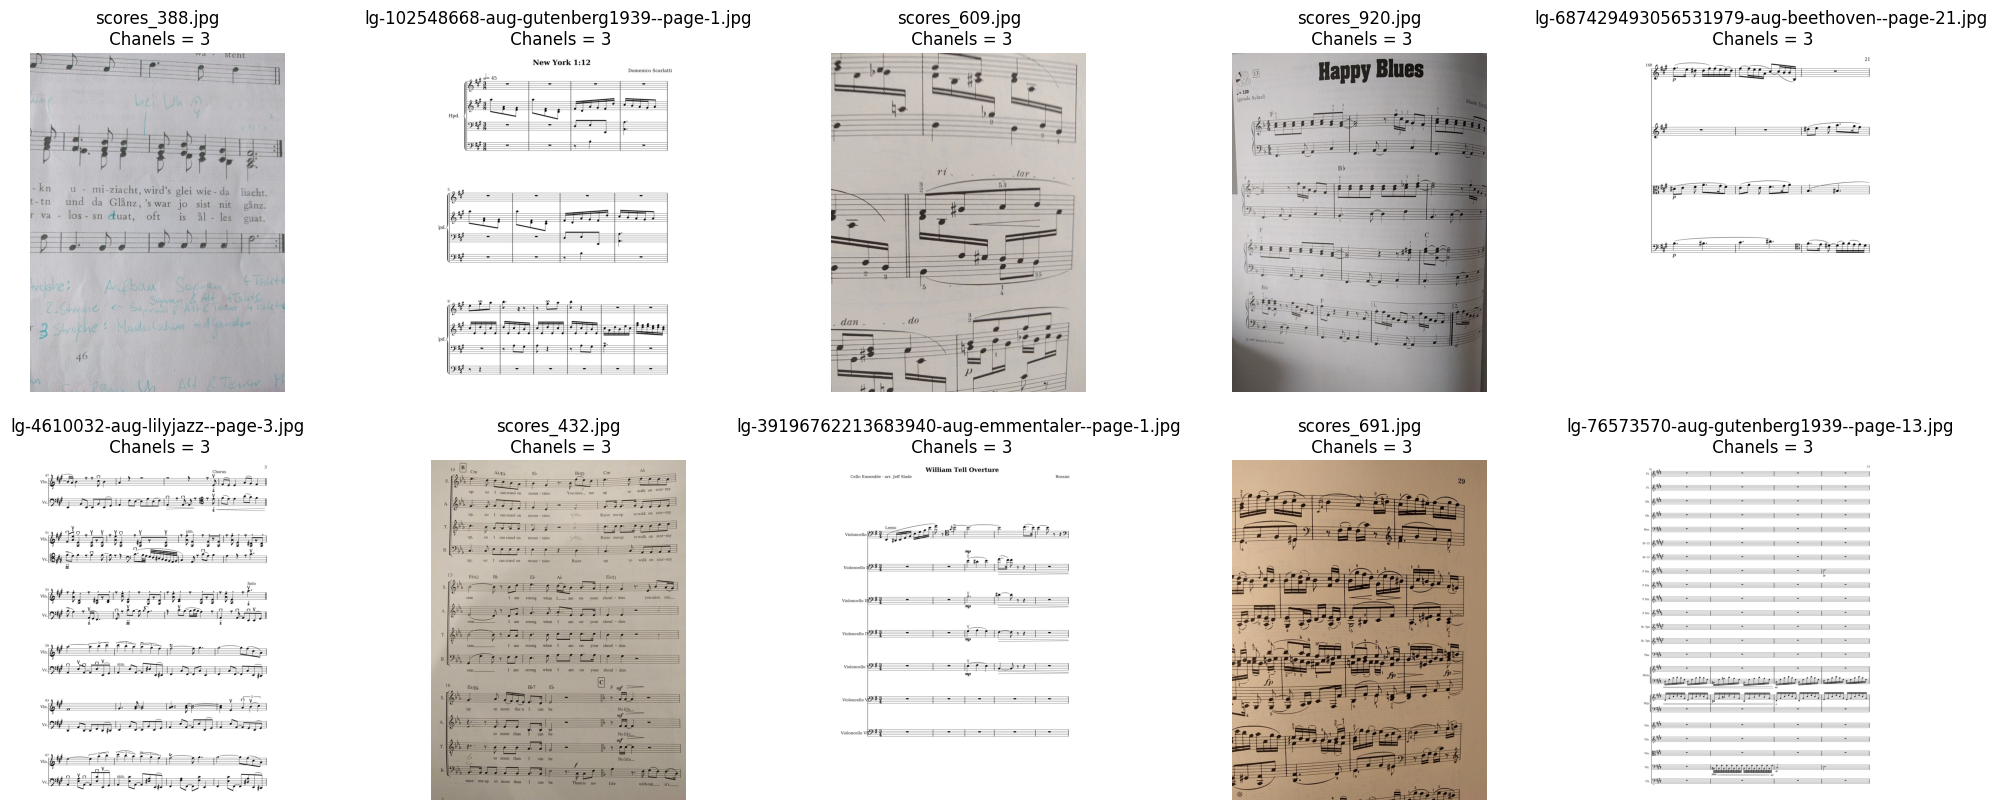

CPU times: user 4.23 s, sys: 402 ms, total: 4.63 s
Wall time: 4.59 s


In [5]:
%%time
pic_box = plt.figure(figsize=(25, 15))
for i, image_name in enumerate(partitures_filenames[5:15]):
    image = plt.imread(str(Path(partitures_data_path, image_name)))

    ax = pic_box.add_subplot(3, 5, i + 1)
    ax.set_title(str(image_name) + "\n Chanels = " + str(image.shape[2]))
    plt.imshow(image)
    plt.axis("off")
plt.show()

## Other images

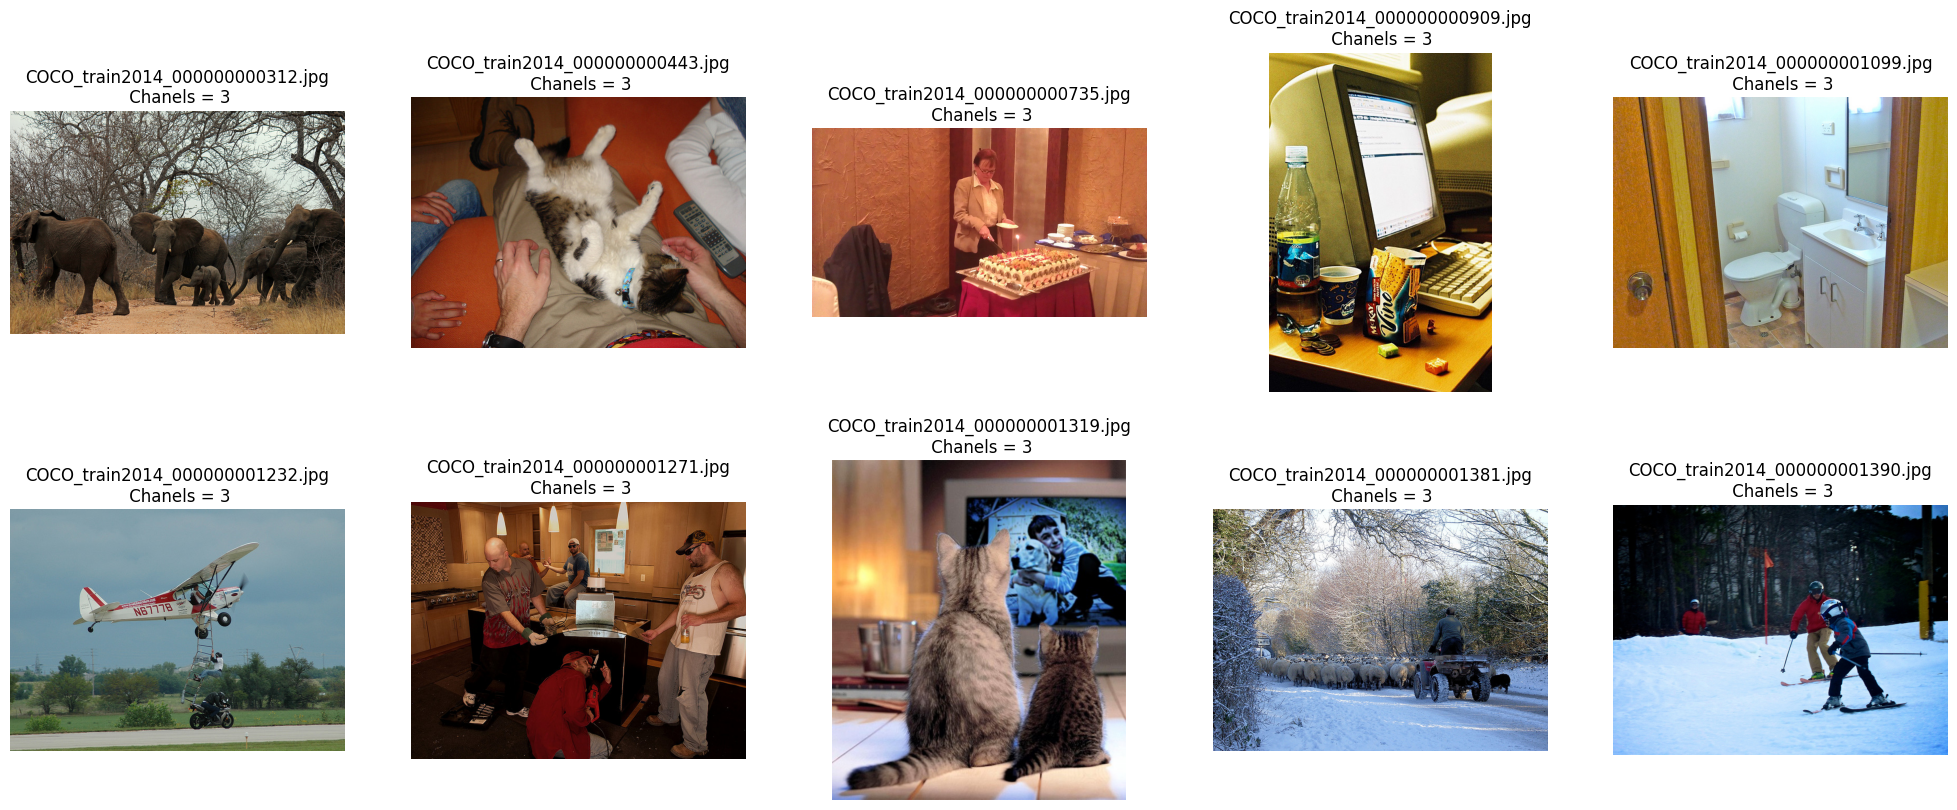

CPU times: user 1.26 s, sys: 164 ms, total: 1.43 s
Wall time: 1.36 s


In [6]:
%%time
pic_box = plt.figure(figsize=(25, 15))
for i, image_name in enumerate(other_filenames[5:15]):
    image = plt.imread(str(Path(other_data_path, image_name)))

    ax = pic_box.add_subplot(3, 5, i + 1)
    ax.set_title(str(image_name) + "\n Chanels = " + str(image.shape[2]))
    plt.imshow(image)
    plt.axis("off")
plt.show()

 # Data augmentation and optimization

In [8]:
%%time
# split data
splitfolders.ratio(
    input_folder, "data_splited", ratio=(0.8, 0.15, 0.05), seed=18, group_prefix=None
)

CPU times: user 512 ms, sys: 3.49 s, total: 4 s
Wall time: 7.74 s


In [9]:
%%time
# normalization parameters
train = ImageDataGenerator(rescale=1 / 255)
val = ImageDataGenerator(rescale=1 / 255)

# generated normalized images
train_data = train.flow_from_directory(
    "data_splited/train",
    target_size=(299, 299),
    class_mode="binary",
    batch_size=3,
    shuffle=True,
)
val_data = val.flow_from_directory(
    "data_splited/val",
    target_size=(299, 299),
    class_mode="binary",
    batch_size=3,
    shuffle=True,
)

Found 8571 images belonging to 2 classes.
Found 1607 images belonging to 2 classes.
CPU times: user 150 ms, sys: 18.5 ms, total: 168 ms
Wall time: 158 ms


In [12]:
# augmentation parameters
data_augmentation = keras.Sequential(
    [
        # Horizontal
        layers.experimental.preprocessing.RandomFlip(
            "horizontal", input_shape=(299, 299, 3)
        ),
        # Random rotate
        layers.experimental.preprocessing.RandomRotation(0.05),
        # Contrast
        layers.experimental.preprocessing.RandomContrast(0.23),
        # Zoom
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

# Build the model and learning

In [13]:
model = Sequential(
    [
        data_augmentation,
        
        layers.Conv2D(16, (3, 3), activation="selu", input_shape=(299, 299, 3)),
        layers.MaxPool2D(2, 2),
        layers.Conv2D(32, (3, 3), activation="selu"),
        layers.MaxPool2D(2, 2),
        layers.Dropout(0.05),
        
        layers.Conv2D(64, (3, 3), activation="selu"),
        layers.MaxPool2D(2, 2),
        layers.Dropout(0.1),
        
        layers.Conv2D(128, (2, 2), activation="selu"),
        layers.MaxPool2D(2, 2),
        layers.Conv2D(256, (2, 2), activation="selu"),
        layers.MaxPool2D(2, 2),
        layers.Dropout(0.2),
        
        layers.Flatten(),
        layers.Dense(500, activation="selu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [14]:
%%time
# model best fit file
checkpoint_filepath = "checkpoints/best_model.h5"

model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(lr=0.00024),
    metrics=["binary_accuracy"],
)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_binary_accuracy",
    mode="max",
    save_best_only=True,
)

history = model.fit(
    train_data,
    batch_size=500,
    verbose=1,
    epochs=35,
    validation_data=val_data,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/35
2857/2857 [==============================] - 446s 156ms/step - loss: 0.7950 - binary_accuracy: 0.8902 - val_loss: 0.2147 - val_binary_accuracy: 0.9384


/home/toni/Aristek_Systems/music_sheet_dubbing/pythonProject/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/35
2857/2857 [==============================] - 419s 147ms/step - loss: 0.2020 - binary_accuracy: 0.9622 - val_loss: 0.1657 - val_binary_accuracy: 0.9490
Epoch 3/35
2857/2857 [==============================] - 400s 140ms/step - loss: 0.1580 - binary_accuracy: 0.9721 - val_loss: 0.4928 - val_binary_accuracy: 0.9191
Epoch 4/35
2857/2857 [==============================] - 358s 125ms/step - loss: 0.1743 - binary_accuracy: 0.9725 - val_loss: 0.1622 - val_binary_accuracy: 0.9720
Epoch 5/35
2857/2857 [==============================] - 360s 126ms/step - loss: 0.1750 - binary_accuracy: 0.9784 - val_loss: 1.0641 - val_binary_accuracy: 0.8911
Epoch 6/35
2857/2857 [==============================] - 362s 127ms/step - loss: 0.1719 - binary_accuracy: 0.9802 - val_loss: 0.1694 - val_binary_accuracy: 0.9876
Epoch 7/35
2857/2857 [==============================] - 358s 125ms/step - loss: 0.2222 - binary_accuracy: 0.9834 - val_loss: 0.3547 - val_binary_accuracy: 0.9664
Epoch 8/35
2857/2857 [======

# Notes

val_binary_accuracy have it's maximum at 28-29 epoch. May be it's enough to have only 30 epochs?
it's CNN model to solve binary classification task
too much parameters in Dense layer.

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model("checkpoints/best_model.h5")
model.summary()

2024-03-07 11:59:54.996902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 11:59:54.996950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 11:59:54.997580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 11:59:55.001716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-07 11:59:55.635194: W tensorflow/compiler/tf2

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 297, 297, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)       

2024-03-07 11:59:56.884607: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32768000 exceeds 10% of free system memory.


# Filter test

In [29]:
from glob import glob
import shutil

In [27]:
dirty_data_path = "dirty_data/"
other_filter_path = "model_filter/other/"
partitures_filter_path = "model_filter/partitures/"

In [28]:
file_names = glob(dirty_data_path + "*.jpg")
len(file_names)

91

In [30]:
for img_path in file_names:
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    pred = model.predict(img_array)
    predicted_class = int(pred[0][0] > 0.5)

    if predicted_class == 0:
        shutil.copy2(img_path, other_filter_path)
    else:
        shutil.copy2(img_path, partitures_filter_path)

1/1 [==============================] - 0s 19ms/step
1
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 18ms/step
0
1/1 [==============================] - 0s 25ms/step
1
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 20ms/step
0
1/1 [==============================] - 0s 20ms/step
1
1/1 [==============================] - 0s 20ms/step
1
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [==============================] - 0s 24ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 22ms/step
0
1/1 [==============================] - 0s 21ms/step
0
1/1 [=======================